Software Project Final Report
===============
####Team: Yunjie Xu and Xi Rao
####I590-34717

####Data Set
We analyzed the reported incidents of crime that happened in Chicago from 2001 to present (minus the most recent seven days). The data is extracted from the Chicago Police Department's CLEAR (Citizen Law Enforcement Analysis and Reporting) system and downloaded from City of Chicago Data Portal ( https://data.cityofchicago.org/). It is in CSV file format, with the size of 1.3GB. The dataset includes the information of crime happening time, block address, primary crime type, a short description, type of the location, district and community area information,  and location information of latitude and longitude. As an example of the size of the data, there are total 5,924,990 incidents recorded till 10/25/2015. 


####Objectives
We want to the explore this crime dataset to find out answers to the following questions. First, how crime rate changes in Chicago in the last fifteen years, including the total crime rate and rates of different types of crimes? Second, visualize the crimes on the map to know which areas are most dangerous in the city. Third, we want to know if we allocate more police to the most dangerous areas, whether other areas will become more dangerous than before.

####Software
We mainly used Python as our analysis toolbox. We build an environment on our local computer, and also put the notebook on the FutureSystem ipython platform. However, some packages in the FutureSystem are old and we don’t have the root authority to update them. Thus some functions are not compatible. But you can still reproduce the environment if you follow the instructions in the notebook on your local computer. 

Github address: https://github.com/bearxu83/Software_Project_34717

>Environment:
* Python 2.7
* Ipython 4.0
* internet connection
* root authorization


In [1]:
#Basic configure for resource names
import os
#If you want to reproduce the result, please modify the crimes_sql path and uncomment the next command
crimes_sql = 'C:\\Users\\AgileBear\\Dropbox\\Work\\Crimes.db'
# !pip install -U pandas folium

need_csv_file = False
#crimes_csv = 'C:\\Users\\AgileBear\\Dropbox\\Work\\Crimes_-_2001_to_present_big.csv'
geo_link = 'https://raw.githubusercontent.com/chriswhong/chicago_geojson/master/chicagoCommunities.geojson'


In [2]:
#download the database to the local env
if not os.path.exists(crimes_sql):
    !wget https://www.dropbox.com/s/g3jfkizui2bjamo/Crimes.db?dl=0 -O {crimes_sql}

As the size of dataset is large for the memory of local computer, especially during analysis, we put the data into a database and treat them as an “out-of-core” dataset. Table 1 listed all the techniques we applied for the project. 

>Table 1: Software packages used

<table>
    <tr>
        <td><b>Package Name</b></td>
        <td><b>Usage</b></td>
    </tr>
    
    <tr>
        <td>IPython Notebook</td>
        <td>write the project report and run the data analysis code</td>
    </tr>
    
    <tr>
        <td>Pandas</td>
        <td>exploratory data analysis</td>
    </tr>
    
    <tr>
        <td>Matplotlib and Folium</td>
        <td>visualize the crime information on the map of Chicago</td>
    </tr>
    
    <tr>
        <td>sqlite</td>
        <td>save and extract data</td>
    </tr>
    
    <tr>
        <td>pip and virtualenv</td>
        <td>install related packages</td>
    </tr>
</table>

In [3]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import folium

In [4]:
#peak the head of the original file
if need_csv_file:
    small_df = pd.read_csv(crimes_csv, header=0, nrows=5)
    small_df

In [5]:
%%timeit -n1 -r1
# save the data from csv file to the database, if you have already downloaded the db, you don't need to execute the block
# DataFrame.to_sql(name, con, flavor='sqlite', schema=None, if_exists='fail', index=True, index_label=None, chunksize=None, dtype=None)
#pandas.read_sql(sql, con, index_col=None, coerce_float=True, params=None, parse_dates=None, columns=None, chunksize=None)
#DataFrame.to_sql(name, con, flavor='sqlite', schema=None, if_exists='fail', index=True, index_label=None, chunksize=None, dtype=None)
if not os.path.exists(crimes_sql) and need_csv_file:
    con = sqlite3.connect(crimes_sql)
    dfs = pd.read_csv(crimes_csv, header=0, parse_dates=['Date', 'Updated On'], chunksize=2000)
    for df in dfs:
        df.to_sql('crimes', con, if_exists='append')

1 loops, best of 1: 188 µs per loop


To build and manage the database, we used SQLite integrated in Python. However, it seemed not optimized for the SSD disk, as some SQL queries are slow under certain conditions. If more time is given, we may find a better replacement. 

In [6]:
#connect to the database
db = sqlite3.connect(crimes_sql)
try:
    cursor = db.execute("CREATE INDEX ix_crimes_primary_type ON crimes ('Primary Type');")
    cursor = db.execute('CREATE INDEX ix_crimes_year ON crimes (YEAR);')
except:
    pass

In [7]:
#show the total crimes cases from 2001 to 2014
total_crimes = pd.read_sql('Select YEAR, COUNT(YEAR) As Total From crimes Group By YEAR Having YEAR < 2015 ', db,  index_col='Year')

####Changes of crime rate in Chicago in the last 14 years 
From the bar chart below, we can clearly conclude that the crime rate is dramatically reduced in the last 14 years, from ~480,000 in 2001 to ~270,000 in 2014. Although we didn’t compare the safety situation in Chicago with other urban cities, the public safety of the city improved a lot compared to its history. The city is much less dangerous, probably due to the application of CLEAR system.


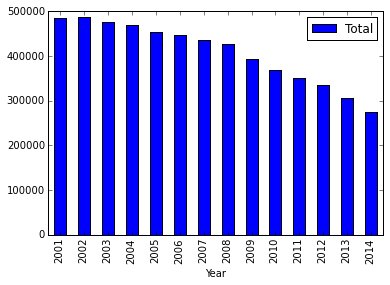

In [8]:
total_crimes.plot(kind='bar')

In [9]:
#show the total crimes except theft from 2001 to 2014
total_crimes_eptheft = pd.read_sql('Select YEAR, COUNT(YEAR) As Total From crimes Where "Primary Type" == "THEFT" Group By YEAR Having YEAR < 2015 ', db,  index_col='Year')

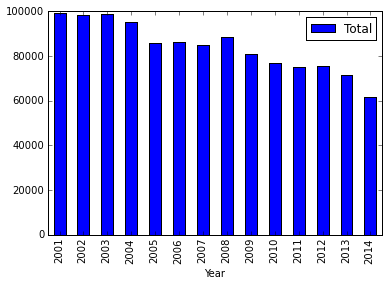

In [10]:
total_crimes_eptheft.plot(kind='bar')

In [11]:
#top crime types
total_types = pd.read_sql('Select "Primary Type" As Primary_Type, COUNT("Primary Type") As Total From crimes Where YEAR < 2015 Group By "Primary Type" Order By Total DESC', db, index_col='Primary_Type')

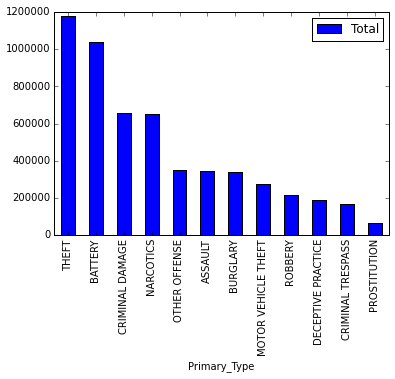

In [12]:
total_types.ix[:12, :].plot(kind='bar')

In [13]:
total_types_years = pd.read_sql('Select "Primary Type" As Primary_Type, YEAR, COUNT(YEAR) As Total From crimes Where YEAR < 2015 Group By "Primary Type", YEAR', db, index_col='Year')
crimes_years_types = pd.pivot_table(total_types_years.reset_index(), values='Total', index='Year', columns=['Primary_Type'])
crimes_years_types

Primary_Type,ARSON,ASSAULT,BATTERY,BURGLARY,CONCEALED CARRY LICENSE VIOLATION,CRIM SEXUAL ASSAULT,CRIMINAL DAMAGE,CRIMINAL TRESPASS,DECEPTIVE PRACTICE,DOMESTIC VIOLENCE,...,OTHER OFFENSE,PROSTITUTION,PUBLIC INDECENCY,PUBLIC PEACE VIOLATION,RITUALISM,ROBBERY,SEX OFFENSE,STALKING,THEFT,WEAPONS VIOLATION
Year,,,,,,,,,,,,,,,,,,,,,
2001,1010,31383,93448,26011,NaN,1793,55851,13240,14886,1,...,29657,6026,9,2750,8,18441,2225,203,99263,4274
2002,1032,31521,94152,25623,NaN,1823,55940,13880,13705,NaN,...,32599,6408,8,2457,2,18522,2166,200,98326,4281
2003,955,29477,88378,25156,NaN,1584,55011,14807,13433,NaN,...,31146,6214,6,2430,2,17332,2065,247,98875,4211
2004,778,28850,87134,24564,NaN,1559,53164,15913,13210,NaN,...,29531,7476,9,2495,1,15978,1800,215,95463,4297
2005,691,27066,83964,25504,NaN,1526,54548,16655,13530,NaN,...,28026,6124,4,2730,2,16047,1799,192,85684,4106
2006,726,25945,80666,24324,NaN,1449,57124,14505,13513,NaN,...,27099,7034,4,3068,7,15968,1559,186,86236,3821
2007,712,26314,79593,24858,NaN,1517,53749,13699,14080,NaN,...,26861,6087,5,3315,1,15450,1515,213,85154,3554
2008,644,25447,75921,26219,NaN,1506,52841,12310,14807,NaN,...,26533,5141,4,3013,NaN,16703,1475,190,88429,3877
2009,616,22861,68462,26765,NaN,1395,47724,10851,13696,NaN,...,25601,3940,10,3147,NaN,15979,1239,167,80971,4158


From the charts below, we can find that the total numbers of nearly all types of crimes are decreased. The four main crime types are theft, battery, criminal damage and narcotics, with highest crime rates among all crime types. We are happy to see that the cases of burglary are reduced in the last three years. Then we looked at the other top crime types and found that only one of them, “deceptive practice”,  is getting worse.

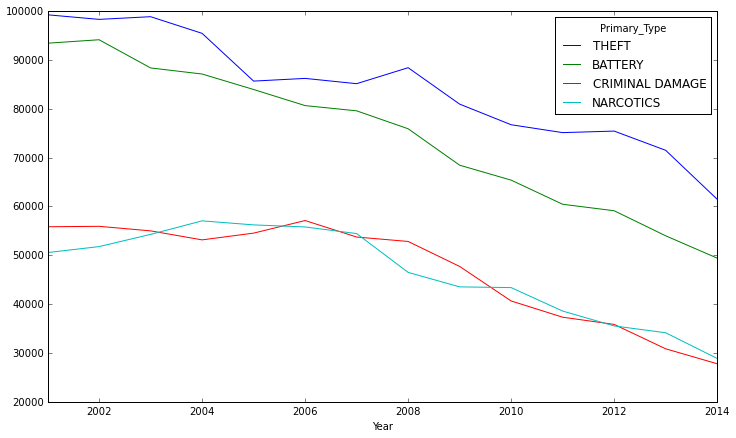

In [14]:
crimes_years_types.ix[:, total_types.ix[:4,:].index].plot(figsize=(12,7))

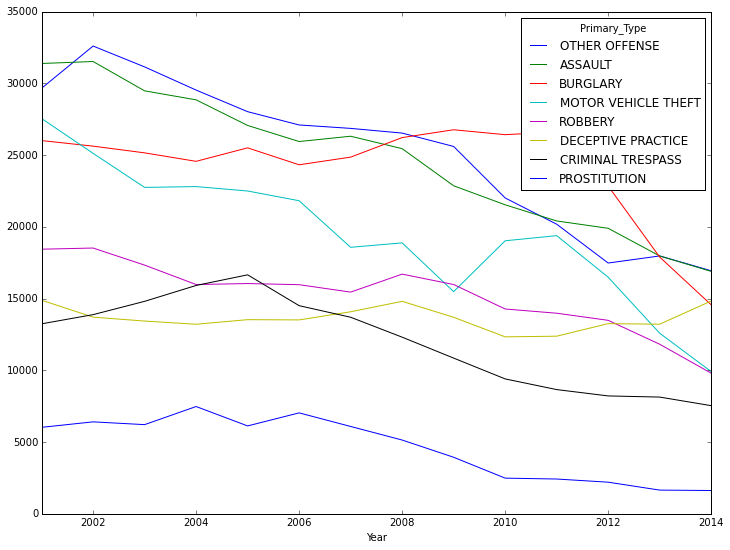

In [15]:
crimes_years_types.ix[:, total_types.ix[4:12,:].index].plot(figsize=(12,9))

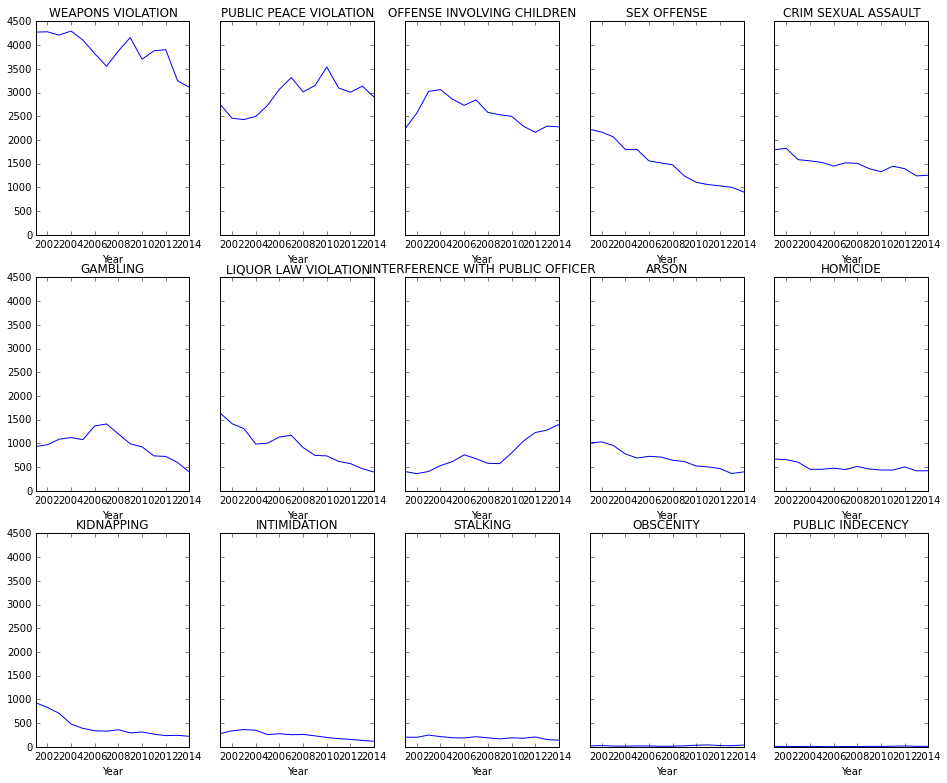

In [16]:
fig, axes = plt.subplots(3, 5, figsize=(16, 13), sharey=True);
k = 0
for i in range(3):
    for j in range(5):
        crimes_years_types.ix[:, total_types.ix[12:,:].index].iloc[:, k].plot(ax=axes[i][j])
        axes[i][j].set_title(crimes_years_types.ix[:, total_types.ix[12:,:].index].columns[k])
        k += 1

We also explore the datetime pattern of the crimes in 2014. From the charts below, we can find that the number of cases increased in the summer, while February was the safest month among the year. In addition,  early morning is a safe time for jogging and it is better to stay inside in the evening, suggesting more police force during these time.

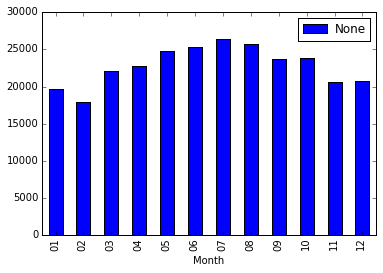

In [17]:
types_months_14 = pd.read_sql('Select "Primary Type" As Primary_Type, strftime("%m", Date) As Month,COUNT("Primary Type") As Total From crimes Where YEAR == 2014 Group By "Primary Type", Month', db)   
#total_types_years.reset_index(), values='Total', index='Year', columns=['Primary_Type']
months_types_14 = pd.pivot_table(types_months_14, index='Month', columns=['Primary_Type'], values='Total')
months_types_14.sum(axis=1).plot(kind='bar', legend='test')

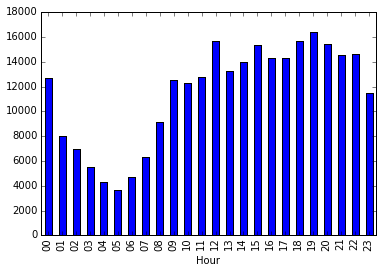

In [18]:
types_hours_14 = pd.read_sql('Select "Primary Type" As Primary_Type, strftime("%H", Date) As Hour,COUNT("Primary Type") As Total From crimes Where YEAR == 2014 Group By "Primary Type", Hour', db)
hours_types_14 = pd.pivot_table(types_hours_14, index='Hour', columns=['Primary_Type'], values='Total')
hours_types_14.sum(axis=1).plot(kind='bar')

In [19]:
crimes_14 = pd.read_sql('Select * From crimes Where YEAR == 2014', db)
stat_community_area = crimes_14.groupby('Community Area', as_index=False).size().reset_index()
stat_community_area.columns = ['CommunityArea', 'Numbers']
stat_community_area['CommunityArea'] = stat_community_area['CommunityArea'].astype(int).astype(str)

####Criminal map of Chicago
The color in the map below indicates the rank of the crime numbers. From the city map, we can see that the urban areas are more dangerous, consistent with the high population in these areas. Some southern areas are dangerous too. The government may need put more efforts into these areas like increasing employment or redevelop the facility in these areas.


In [23]:
# test_df = pd.DataFrame(zip((str(i) for i in range(1, 80)), (i*10 for i in range(1, 80))))
# test_df.columns = ['a', 'b']
# chicago_map = folium.Map(location=[48, -102], zoom_start=3)
# chicago_map.geo_json(geo_path=geo_link, data=test_df, columns=['a', 'b'],  fill_color='YlGn', key_on='feature.properties.area_numbe')
# chicago_map.create_map()
# chicago_map
chicago_map = folium.Map(location=[41.8369, -87.6847], zoom_start=9, max_zoom=10, min_zoom=9)
chicago_map.geo_json(geo_path=geo_link, data=stat_community_area, columns=['CommunityArea', 'Numbers'],  fill_color='YlOrRd', key_on='feature.properties.area_numbe',
    threshold_scale=[2, 2000, 3500, 5000, 7000],
    fill_opacity = 0.7
)
chicago_map.create_map()
chicago_map

####Effect of reallocating police force on crime rate
Now another question is raised after we have the maps. If we allocate more police to the red areas, will it affect crime rate in other areas? We can also assume that the Chicago police has already use the distribution map to reallocate their power.


In [21]:
total_ca_years = pd.read_sql('Select "Community Area" As Community_Area, YEAR, COUNT("Community Area") As Total From crimes Where YEAR < 2015 Group By "Community Area", YEAR', db, index_col='Year')
top_charts = {}
for y in range(2002, 2015):
    this_year = set(total_ca_years.dropna().loc[y, :].sort('Total', ascending=False)['Community_Area'][:10].astype(int))
    last_year = set(total_ca_years.dropna().loc[y-1, :].sort('Total', ascending=False)['Community_Area'][:10].astype(int))
    diff = len(this_year - last_year)
    top_charts[y] = diff
top_charts

{2002: 3,
 2003: 1,
 2004: 0,
 2005: 0,
 2006: 1,
 2007: 0,
 2008: 0,
 2009: 1,
 2010: 1,
 2011: 0,
 2012: 2,
 2013: 0,
 2014: 1}

We rank top 10 dangerous community areas in the city every year and see how much the rank changes. From the result above we see that the top 10 dangerous community areas are nearly all the same. The distribution is relatively stable. It suggests that the Chicago police can allocate more power to these areas to improve the public safety.

####Future Work
Due to the limited time, we didn't explore the geolocation infomation in the dataset too much. By using the location data, we can get some useful information like which types of crime often happen around schools etc.